In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Optimisation

The goal is to play around with different optimisation methods. I will try to understand them, code them up from scratch, and try them out on some cool objective functions. If I have time, I will try to use Jax or some other autograd library to do additional implementations of the gradient-based optimisation methods.

## Optimisation Methods

### Steepest Descent / Gradient Descent

Taylor's theorem implies that:
$$f(\theta + \Delta) \simeq f(\theta) + \nabla f(\theta)^{T} \cdot \Delta $$
Which will be minimised in $\Delta$ by setting $\Delta \propto -\nabla f(\theta) $. Using this as our direction for selecting the next $\theta$, one would still need to choose an appropriate step length, telling us how far to go in that direction. First, we consider a fixed step size, giving: $\Delta = \alpha \cdot -\nabla f(\theta), \, \alpha \in \mathbb{R}^{+}$.

In [2]:
# Let's code it!

def GD_method(theta_0,f,grad,alpha,method='Iterations',maxiter=100,epsilon=10e-2):
    
    iter_count = 0
    theta_list = [np.array(theta_0)] #final list to be returned

    while True:

        cur_theta = theta_list[iter_count] # fetch current value
        theta_list.append(cur_theta + alpha * -grad(cur_theta)) # update
        iter_count+=1

        if method == 'Iterations':
            if iter_count>maxiter:

                print('Max number of iterations reached: '+str(maxiter))
                print('Final objective function value '+str(f(theta_list[-1]))+' reached at '+str(theta_list[-1]))
                return theta_list

        if method == 'Epsilon':
            if np.abs(f(cur_theta)-f(theta_list[-1]))<epsilon:
                print('Minimal tolerance reached with number of iterations: '+str(iter_count))
                print('Final objective function value '+str(f(theta_list[-1]))+' reached at '+str(theta_list[-1]))
                return theta_list


### Newton's Method

Same principle as GD: we make use of Taylor's theorem to find the step that will minimise the function. Here, we also use the second order term, getting:

$$ f(\theta + \Delta) \simeq f(\theta) + \nabla f(\theta)^T \cdot \Delta + \frac{1}{2} \Delta^T \cdot \nabla^2 f(\theta) \cdot \Delta $$
This quadratic model is minimised in terms of $\Delta$ when $\nabla^2 f(\theta)\cdot \Delta = -\nabla f(\theta)$, but only if $\nabla^2f(\theta)$ is positive definite. To circumvent this, we can just add multiples of the identity matrix to the Hessian until it becomes p.d. (inflate the diagonal), which as it turns out, points the search direction towards that of GD. The inflation of the diagonal works because the function is minimised for any choice of p.d. matrix used.

In [3]:
# coding time!

def NM(theta_0,f,grad,hes,maxiter=10,tolerance=1e-6):

    # Initialise function value, gradient and Hessian as well as iteration count
    current = [f(theta_0),grad(theta_0),hes(theta_0),np.array(theta_0)]
    out = [current]
    iter_count = 1
    
    if hasattr(theta_0, "__len__")==False: # Univariate case
        while iter_count<maxiter+1:

            step = -(1/current[2])*current[1] # update step

            while f(current[3]+step)>=f(current[3]): # check for decrease
                step= step/2 # get closer to local behaviour by decreasing step size

                if np.linalg.norm(step) <tolerance: # check for convergence and terminate if true
                    print('Terminated due to convergence. Number of evaluations: '+str(iter_count))
                    print('Final function value: '+str(current[0]) + ' reached at theta = '+str(current[3]))
                    print('[fval,gradient,hessian,theta] reported as:')
                    return out 

            new_theta = current[3]+step # update theta
            current = [f(new_theta),grad(new_theta),hes(new_theta),new_theta] # update f, grad, hes
            out.append(current)
            iter_count+=1

        # All iterations done, terminate
        print('Terminated due to reaching number of evaluations: '+str(iter_count))
        print('Final function value: '+str(current[0]) + ' reached at theta = '+str(current[3]))
        print('[fval,gradient,hessian,theta] reported as:')
        return out

    else: # multivariate case
        while iter_count<maxiter+1:

            while np.all(np.linalg.eigvals(current[2]) < 0):
                current[2]=current[2]+np.eye(len(theta_0))
                print('Making Hessian p.d. by inflating diagonal :',current[2])

            step = -np.matmul(np.linalg.inv(current[2]),current[1]) #update step

            while f(current[3]+step)>=f(current[3]): #check for decrease
                step= step/2 # get closer to local behaviour
                if np.linalg.norm(step) <tolerance: #check for convergence
                    print('Terminated due to convergence. Number of evaluations: '+str(iter_count))
                    print('Final function value: '+str(current[0]) + ' reached at theta = '+str(current[3]))
                    print('[fval,gradient,hessian,theta] reported as:')
                    return out # terminate
            new_theta = current[3]+step
            current = [f(new_theta),grad(new_theta),hes(new_theta),new_theta] # update f, grad, hes
            out.append(current)
            iter_count+=1
        print('Terminated due to reaching number of evaluations: '+str(iter_count))
        print('Final function value: '+str(current[0]) + ' reached at theta = '+str(current[3]))
        print('[fval,gradient,hessian,theta] reported as:')
        return out


### Nelder-Mead Polytope Method

If gradient information is not easily available, we can just rely on function evaluations. The N-M polytope method works as folows:
- For a collection of $n$ points, identify the point with the highest function value.
- Form a vector from the worst point to the average of the remaining $n-1$ points.
- Try a step following that vector with a size of 2x the distance from the worst point to the avergare of the others. If the function is lowered, also try a size of 1.5x that distance and choose the better of the two.
- If the funciton is not lowered with a size of 2x, choose best between 0.5x and 1.5x.
- If that fails too, reduce the polytope by rescaling to the best points out the $n$ considered.
- After accepting a point, discard the worst point to maintaign $n$ points.

This method is prone to getting stuck in local minima, so it is worth starting with different polytopes.

In [4]:
# Coding it!

def NeMe_poly(n_0,f,maxiter=10):

    # Initialize polytope, f-evals and iterations
    n_poly = np.array(n_0)
    out = [n_poly] #list of polytopes to be returned
    f_n = [f(theta) for theta in n_poly]
    iter_count = 0

    while iter_count<maxiter:
        iter_count+=1
        print('iter:',iter_count)

        l_idx = np.argmax(f_n) #identify max
        print('worst:',n_poly[l_idx])
        avg = np.mean(np.stack([np.array(v) for v in n_poly if v!=n_poly[l_idx]]),axis=0) # centroid
        step_dir = avg-n_poly[l_idx] # direction
        print('dir:',step_dir)
        if f(n_poly[l_idx]+2*step_dir)<f_n[l_idx]: # 2x lowers
            if f(n_poly[l_idx]+2*step_dir)<f(n_poly[l_idx]+1.5*step_dir): # 2x better than 1.5x
                #update point and f-eval
                print('2',n_poly[l_idx]+2*step_dir)
                n_poly[l_idx] = n_poly[l_idx]+2*step_dir
                f_n[l_idx] = f(n_poly[l_idx])

            else: # 1.5x is better
                print('1.5')

                #update point and f-eval
                print(n_poly[l_idx],n_poly[l_idx]+1.5*step_dir)
                n_poly[l_idx] = float(n_poly[l_idx]+1.5*step_dir)
                f_n[l_idx] = f(n_poly[l_idx])
                print(n_poly)

        elif(n_poly[l_idx]+1.5*step_dir)<f_n[l_idx]:  # 2x is bad, but 1.5x lowers
            if f(n_poly[l_idx]+1.5*step_dir)<f(n_poly[l_idx]+0.5*step_dir): # 1.5x better than 0.5x
                #update point and f-eval
                n_poly[l_idx] = n_poly[l_idx]+1.5*step_dir
                f_n[l_idx] = f(n_poly[l_idx])
                print('1.5, but out of 0.5',n_poly[l_idx],n_poly[l_idx]+1.5*step_dir)

            else: # 0.5x is better
                #update point and f-eval
                n_poly[l_idx] = n_poly[l_idx]+1.0*step_dir
                f_n[l_idx] = f(n_poly[l_idx])
                print('0.5')

        else: # need to reduce polytope
            w_idx = np.argmin(f_n)
            print('Rscale')
            print(n_poly)
            # rescale each point closer to the best point
            for id,point in enumerate(n_poly):
                if id!=w_idx:
                    n_poly[id] = np.mean(np.stack([point,n_poly[w_idx]]),axis=0)
            print(n_poly)

        out.append(n_poly)
        print('end. n_poly:',n_poly)
    return out


In [85]:
# This function has a different selection process for the step length. IT simply chooses the best out of 0.5,1.5 and 2.

def Nelder_Mead_poly(polytype_0,f,maxiter=3,tolerance=1e-10):

    # Initialise
    n_poly = np.array(polytype_0)
    out = [np.array(polytype_0)]
    f_n=[f(theta) for theta in n_poly]
    iter_count = 0
    stopper_count = 0

    while iter_count<maxiter:

        l_idx = np.argmax(f_n) # identify worst point
        avg = np.mean([n_poly[i] for i in range(len(n_poly)) if i!=l_idx],axis=0) # centroid
        direction = avg - n_poly[l_idx] # direction of step
        proposal_points = [n_poly[l_idx]+k*direction for k in [0.5,1.5,2]] # possible new points
        proposal_fvals = [f(pp) for pp in proposal_points ] # function values at proposal points
        best_step_idx = np.argmin(np.array(proposal_fvals)) # identify best step 

        # update polytope and function value
        n_poly[l_idx] = proposal_points[best_step_idx]
        f_n[l_idx] = proposal_fvals[best_step_idx]
        out.append(np.array([k for k in n_poly]))

        iter_count+=1

        if np.sum([np.absolute(n_poly[l_idx]-k) for k in n_poly])<tolerance: #check for convergence
            stopper_count+=1
            if stopper_count>2: # has to not change by much 3 times
                print(' Convergance termination after ',iter_count, ' steps.' )
                print('Lowest fval:',np.min(f_n),' achieved at theta: ',n_poly[np.argmin(f_n)])

                return out
        else:
            stopper_count = 0

    print('Lowest fval:',np.min(f_n),' achieved at theta: ',n_poly[np.argmin(f_n)])

    return out

In [86]:
Nelder_Mead_poly([40,33],x2,9)

Lowest fval: 0.0  achieved at theta:  0


[array([40, 33]),
 array([26, 33]),
 array([26, 19]),
 array([12, 19]),
 array([12,  5]),
 array([1, 5]),
 array([ 1, -1]),
 array([ 0, -1]),
 array([0, 0]),
 array([0, 0])]

In [90]:
Nelder_Mead_poly([[2,2],[13,13],[np.pi,4]],Ros,1000,1e-15)

 Convergance termination after  141  steps.
Lowest fval: 0.0  achieved at theta:  [1. 1.]


[array([[ 2.        ,  2.        ],
        [13.        , 13.        ],
        [ 3.14159265,  4.        ]]),
 array([[ 2.        ,  2.        ],
        [-2.64380551, -2.        ],
        [ 3.14159265,  4.        ]]),
 array([[ 2.        ,  2.        ],
        [-0.03650459,  0.5       ],
        [ 3.14159265,  4.        ]]),
 array([[ 2.        ,  2.        ],
        [-0.03650459,  0.5       ],
        [-0.09817477, -0.125     ]]),
 array([[ 0.96633016,  1.09375   ],
        [-0.03650459,  0.5       ],
        [-0.09817477, -0.125     ]]),
 array([[ 0.96633016,  1.09375   ],
        [ 0.66936884,  0.4765625 ],
        [-0.09817477, -0.125     ]]),
 array([[0.96633016, 1.09375   ],
        [0.66936884, 0.4765625 ],
        [0.35983736, 0.33007812]]),
 array([[0.96633016, 1.09375   ],
        [0.66936884, 0.4765625 ],
        [1.04685557, 1.01269531]]),
 array([[0.80400322, 0.57006836],
        [0.66936884, 0.4765625 ],
        [1.04685557, 1.01269531]]),
 array([[0.80400322, 0.57006

In [7]:
Nelder_Mead_poly([1,10],x2,3)

NameError: name 'x2' is not defined

In [65]:
np.stack([np.array(v) for v in [[1],[10]] if v!=[1]])

array([[10]])

In [101]:
10-1.5*9

-3.5

In [8]:
NeMe_poly([[1],[10]],x2,10)

NameError: name 'x2' is not defined

In [58]:
np.mean(np.stack([a1,a2]))

9.75

In [57]:
a1=np.array([1,4])
a1[0]=10
a2=np.array([5,20])
a3=np.array([0,0])
k=np.stack([a1,a2,a3])
print(k)
np.mean(k,axis=0)

[[10  4]
 [ 5 20]
 [ 0  0]]


array([5., 8.])

In [52]:
NeMe_poly([11,15],x2)

-4.0

## Objective Functions

## X^2

GD: 
Minimal tolerance reached with number of iterations: 21
Final objective function value 1.7408531802450453e-16 reached at -1.3194139533311922e-08
Newton's Method:
Terminated due to convergence. Number of evaluations: 2
Final function value: 0.0 reached at theta = 0.0
[fval,gradient,hessian,theta] reported as:


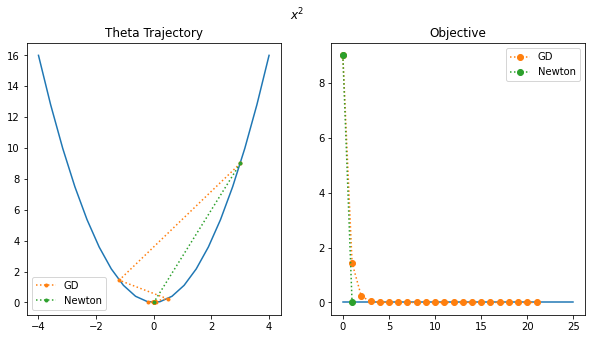

In [9]:
def x2(x):
    return np.power(x,2)
def x2_grad(x):
    return 2*x

def x2_hes(x):
    return 2

print('GD: ')
theta_vals_GD = GD_method(3,x2,x2_grad,0.7,method='Epsilon',epsilon=10e-16)
print("Newton's Method:")
theta_vals_NM = NM(3,x2,x2_grad,x2_hes,10,1e-10)
labels = ['GD','Newton']

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('$x^2$')
ax1.plot(np.linspace(-4,4,20),[x2(x) for x in np.linspace(-4,4,20)])
ax2.plot([0,25],[0,0],'-')
for idx,theta_vals in enumerate([theta_vals_GD,[i[3] for i in theta_vals_NM]]):
    ax1.plot(theta_vals,[x2(i) for i in theta_vals],marker='o',linestyle='dotted',markersize=3,label=labels[idx])
    ax2.plot([x2(x) for x in theta_vals],label=labels[idx],linestyle='dotted',marker='o')

ax1.set_title('Theta Trajectory')
ax2.set_title('Objective')
ax1.legend()
ax2.legend()
fig.set_size_inches(10,5)
plt.show()

### Rosenbrock function

This is a non-convex function defined by:
$$ f(x,y) = (a-x)^2 +b(y-x^2)^2 $$ 
for $a,b \in \mathbb{R}$. The function always has a global minimum at $(a,a^2)$. Here I take $a=1, b=100$ which seems to be the reference example. 
Then, this function has a gradient of $\nabla f(x,y) = (400x^3-400xy+2x-2,\,200(y-x^2))$.

GD: 
Max number of iterations reached: 200000
Final objective function value 1.0750282206404076e-08 reached at [0.9998964  0.99979239]
Newton's Method: 
Terminated due to convergence. Number of evaluations: 33
Final function value: 0.0 reached at theta = [1. 1.]
[fval,gradient,hessian,theta] reported as:


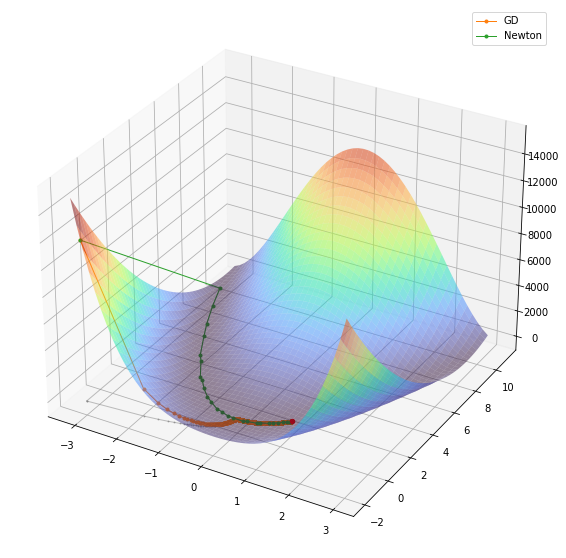

In [12]:
def Ros(theta,a=1,b=100):
    x,y=theta
    return np.power((a-x),2) + b*np.power((y-np.power(x,2)),2)
def Ros_grad(theta):
    x,y=theta
    return np.array([400*np.power(x,3)-400*x*y+2*x-2, 200*(y-np.power(x,2))])

def Ros_hes(theta):
    return np.array([[1200*np.power(theta[0],2)-400*theta[1]+2, -400*theta[0]],[-400*theta[0], 200]])

y = np.linspace(-2, 11, 50)
x = np.linspace(-3.2, 3, 50)
X, Y = np.meshgrid(x, y)
Z = Ros([X, Y])
%matplotlib inline
fig = plt.figure()
fig.set_size_inches(10,10)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='turbo', edgecolor='none',alpha=0.5)
print('GD: ')
theta_vals_GD = GD_method([-3,-2],Ros,Ros_grad,10e-5,method='Iterations',maxiter=200000)
print("Newton's Method: ")
theta_vals_NM = NM([-3,-2],Ros,Ros_grad,Ros_hes,50)
labels = ['GD','Newton']

for idx,theta_vals in enumerate([theta_vals_GD,[i[3] for i in theta_vals_NM]]):
    ax.plot3D([i[0] for i in theta_vals],[i[1] for i in theta_vals],[0 for i in theta_vals],color='grey',linewidth=1,marker='o',markersize=1,alpha=0.5)
    ax.plot3D([i[0] for i in theta_vals],[i[1] for i in theta_vals],[Ros(i) for i in theta_vals],label=labels[idx],linewidth=1,marker='o',markersize=3)
ax.scatter3D(1,1,0,color='red')
plt.legend()
plt.show()